This is a demonstration of several tools designed to statistically aggregate rasters.  The basic functionality is to "stack" rasters, and compute summary statistics on each pixel.  What makes this toolkit more helpful than standard GIS approaches is that it is designed to facilitate exploratory analysis, by leveraging the power of nd arrays in numpy/scipy, and by allowing statistical comparisons between the stacks.  It is expected that these tools will be folded into the Near Earth Imaging Lab Pythong Toolkit (neilpy) soon.

The data for this demo was collected by Hannah Eboh as part of her master's thesis.  These tools were developed to facilite data analysis for that thesis.

In [1]:
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

%matplotlib inline

Data about participants, including filenames to the digitized versions of their risk perception maps are located in an Excel spreadsheet.  This is loaded to facilitate the creation of the raster stacks.

In [2]:
attrib_file = 'Coded surveys.xlsx'
raster_dir = 'All rasters/'

df = pd.read_excel(attrib_file)

df.head()

,location,part_id,filename,years,age,gender,education,distance2,Distance Km,distance,participant,experiancial,ancestral,educational,Unnamed: 14
0,La Plaine,1.1,1.1.tif,51.0,mid,male,less,near,4.0,near,yes,yes,yes,yes,1.1.tif
1,La Plaine,1.2,1.2.tif,83.0,mid,female,less,near,4.0,near,yes,yes,no,no,NaN
2,La Plaine,1.3,1.3.tif,86.0,older,female,less,near,4.0,near,yes,yes,yes,no,NaN
3,La Plaine,1.4,1.4.tif,47.0,mid,male,less,near,4.0,near,yes,no,no,no,NaN
4,La Plaine,1.5,1.5.tif,23.0,young,male,college,near,4.0,near,yes,no,yes,yes,NaN


## Defining a program to stack rasters

Next, we definte a simple tool to stack the rasters.  Given a list of filenames and an optional path, the rasters are stacked in a numpy array.  This is probably not suitable for large rasters with many, many stacks.  Your mileage will vary based on available memory.  You can also request to return the georeferencing information.  It is assumed that all rasters align; the program will make no attempt to check alignmnent.

In [3]:
def stacker(fns,path='./',verbose=False,return_georeferencing=False):
    
    # Load the first raster to get width and height
    read_success, i = False, 0
    while not read_success and i<len(fns):
        fn = fns[i]
        try:
            with rasterio.open(path + fn) as src:
                I = src.read(1)
                af = src.affine
                gt = src.get_transform()
                crs = src.get_crs()
                nodata_value = src.get_nodatavals()[0]
                raster_size = np.shape(I)
            read_success = True
        except:
            i=i+1
                
    if read_success:
        
        # Create composite, including a spot to count unloadable rasters
        composite = np.zeros((np.sum(len(fns)),raster_size[0],raster_size[1]),dtype=np.float)
        loaded_count = 0
        bad_list = []
        
        # Load the rasters
        for i,fn in enumerate(fns):
            if verbose:
                print(fn)
            read_success = False
            try:
                with rasterio.open(path + fn) as src:
                    I = src.read(1)
                    gt = src.get_transform()
                    crs = src.get_crs()
                    nodata_value = src.get_nodatavals()[0]
                    raster_size = np.shape(I)
                read_success = True
            except:
                print('Could not read:',fn)
                bad_list.append(i)
            if read_success:
                nodata_mask = I==nodata_value
                composite[i] =I
                loaded_count = loaded_count + 1  
                
        # Eliminate the bad loads and return the stack
        composite = np.delete(composite,bad_list,0)
        composite[:,nodata_mask] = np.nan
        print(np.shape(composite)[0],'rasters loaded.')
        if return_georeferencing==True:
            metadata = {'affine':af,'geotransform':gt,'crs':crs,'nodata_value':nodata_value,'raster_size':raster_size}
            return composite, metadata
            
        else:
            return composite
    else:
        print('\nCould not read any rasters!  Try specifying the path to them?')
        return None
    
def normalize(stacks):
    # Process per item normalization:
    stacks = list(stacks)
    stacks = [(item-np.nanmean(item)) / np.nanstd(item) for item in stacks]
    stacks = tuple(stacks)    
    return stacks

## Calculating and visualizating statistics on the stacks of rasters

Could not read: 1.1.tif
Could not read: 1.4.tif
77 rasters loaded.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


90 rasters loaded.
Mean pixel value of A is: 2.37088555272
Mean pixel value of B is: 2.19709310157


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


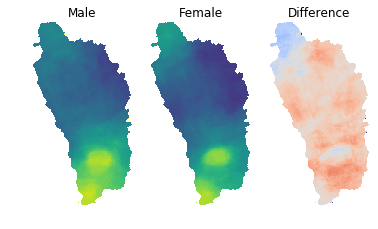

In [4]:
# At this point, it is straightforward to stack rasters, and perform simple descriptive statistics:

idx = df.gender=='male'
A, md = stacker(df.loc[idx,'filename'].values,path="All rasters/",return_georeferencing=True)
A = np.nanmean(A,axis=0)

idx = df.gender=='female'
B, md = stacker(df.loc[idx,'filename'].values,path="All rasters/",return_georeferencing=True)
B = np.nanmean(B,axis=0)

print('Mean pixel value of A is:',np.nanmean(A))
print("Mean pixel value of B is:",np.nanmean(B))

C = A - B

plt.subplot(131)
plt.imshow(A,vmin=1,vmax=4,)
plt.title('Male')
plt.axis('off')

plt.subplot(132)
plt.imshow(B,vmin=1,vmax=4)
plt.title('Female')
plt.axis('off')

plt.subplot(133)
plt.imshow(C,vmin=-1,vmax=1,cmap='coolwarm')
plt.title('Difference')
plt.axis('off')

plt.savefig('sex_differences_plot.png',dpi=300,bbox_inches='tight')

In [5]:
# Individual aggregates can also be saved

with rasterio.open('male.tif', 'w', driver='GTiff', 
                             height=md['raster_size'][0], width=md['raster_size'][1],
                             count=1, dtype=np.float32, transform=md['affine']) as src:
    src.write(A.astype(np.float32), 1)
plt.imsave('male.png',A,vmin=1,vmax=4,dpi=300)


with rasterio.open('female.tif', 'w', driver='GTiff', 
                             height=md['raster_size'][0], width=md['raster_size'][1],
                             count=1, dtype=np.float32, transform=md['affine']) as src:
    src.write(B.astype(np.float32), 1)
plt.imsave('female.png',B,vmin=1,vmax=4,dpi=300)

with rasterio.open('sex_differences.tif', 'w', driver='GTiff', 
                             height=md['raster_size'][0], width=md['raster_size'][1],
                             count=1, dtype=np.float32, transform=md['affine']) as src:
    src.write(C.astype(np.float32), 1)
plt.imsave('sex_differences.png',C,cmap='coolwarm',vmin=-1,vmax=1,dpi=300)


## Defining statistical functions

We are explicity interested in finding whether there is statistical difference between groups with respect to each pixel.  We define several statistical tests.  T-tests can be run without looping; non-parametric test and ANOVAs must be run a pixel at a time.  These methods are gathered here into a single function for convenience.

In [6]:
def raster_stattest(stacks,test,popmean=0,nan_policy='omit',equal_var=False):
    if not type(stacks)==tuple:
        stacks = (stacks,)
   
    raster_size=(np.shape(stacks[0])[1],np.shape(stacks[0])[2])
    P = np.zeros(raster_size,dtype=np.float)
    P[:] = np.nan
    if test=='ttest_1samp':
        if np.ndim(popmean) > 0:
            stacks = (stacks[0] - popmean,)
            popmean = 0
        T, P = stats.ttest_1samp(stacks[0],popmean=popmean,axis=0,nan_policy=nan_policy)      
        return T,P
    elif test=='ttest_ind':
        T,P = stats.ttest_ind(stacks[0],stacks[1],axis=0,equal_var=equal_var,nan_policy=nan_policy)
        return T,P
    elif test=='mannwhitneyu':
        U = P.copy()
        for i in range(raster_size[0]):
            for j in range(raster_size[1]):
                result = stats.mannwhitneyu(A[:,i,j],B[:,i,j])
                P[i,j] = result[1]
                U[i,j] = result[0]
        U[np.isnan(A[0,:,:])] = np.nan
        P[np.isnan(A[0,:,:])] = np.nan
        return U,P
    elif test=='f_oneway':
        F = P.copy()
        for i in range(raster_size[0]):
            for j in range(raster_size[1]):
                this_stack = []
                for k in range(len(stacks)):
                    this_stack.append(stacks[k][:,i,j])
                    result = stats.f_oneway(*this_stack)
                    P[i,j] = result[1]
                    F[i,j] = result[0]
        return F,P
    elif test=='kruskal':
        H = P.copy()
        for i in range(raster_size[0]):
            for j in range(raster_size[1]):
                this_stack = []
                for k in range(len(stacks)):
                    this_stack.append(stacks[k][:,i,j])
                    try:
                        result = stats.kruskal(*this_stack)
                    except:
                        result = (np.nan,np.nan)
                    P[i,j] = result[1]
                    H[i,j] = result[0]
        return H,P
    else:
        print('Test not yet supported.')
        return None
        

## Calculating effect sizes on rasters

We are generally interested in calculating effect sizes using Cohen's d, as it is widely used.  A few references:

Primary sources:
Lakens, 2013: https://www.frontiersin.org/articles/10.3389/fpsyg.2013.00863/full
Psychometrica.de: https://www.psychometrica.de/effect_size.html

<P>Additional sources:
https://www.uccs.edu/lbecker/effect-size
https://www.youtube.com/watch?v=TmXEIUmy-YU
https://www.itl.nist.gov/div898/software/dataplot/refman2/auxillar/hedgeg.htm
http://www-01.ibm.com/support/docview.wss?uid=swg21476421

There are several variants, so the reader is encouraged to review these and other statistical sources to familiarize themselves with the test and its variants.

In [7]:
# The most general form of Cohen's D, to which two stacks of rasters are provided.  These uses a weighted pooled sd to 
# support the calculation using different sample sizes.

# Identical to https://www.psychometrica.de/effect_size.html #1 using Hedges g 
# formula at https://stats.idre.ucla.edu/other/mult-pkg/faq/general/effect-size-power/faqhow-is-effect-size-used-in-power-analysis/
# Also identical to Lakens, 2013 Formula 1.

def pooled_sd(A,B,axis=0):
    N1 = np.sum(np.isfinite(A),axis=axis)
    N2 = np.sum(np.isfinite(B),axis=axis)
    SD1 = np.nanstd(A,axis=axis)
    SD2 = np.nanstd(B,axis=axis)
    psd = np.sqrt((((N1-1)*(SD1**2) + (N2-1)*(SD2**2)) / (N1+N2-2)))
    return psd

def cohen_d(A,B,axis=0):
    M = np.nanmean(A,axis=axis) - np.nanmean(B,axis=axis)
    D = M / pooled_sd(A,B,axis=axis)
    return D


# Calculate Cohen's D based on results from a one-sample t-test.
# See Equation 7 (Lakens, 2017) and https://www.youtube.com/watch?v=yGc1a324t14&t=381s.

def cohen1(T,N):
    D = T / np.sqrt(N)    
    return D


#%% To be used for independent / between-subjects design to convert T to D.  Should be nearly
# identical to cohen_d above.  See equation 2 and subsequent approximation in 
# https://www.frontiersin.org/articles/10.3389/fpsyg.2013.00863/full

def cohen_ds(T,N,N2=None):
    if N2==None:
        ds = 2 * T / np.sqrt(N)
    else:
        ds = T * np.sqrt((1/N) + (1/N2))
    return ds


#%% See file:///C:/Users/Thomas%20Pingel/Desktop/Effect_Sizes_pdf5.pdf, equation 5
# Cited by 
def cohen_from_F2(F,N1,N2):
    D = np.sqrt(F*(((N1+N2) / (N1*N2)) * ((N1+N2)/(N1+N2-2))))
    return D


# See https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test
# and https://www.youtube.com/watch?v=pqi86z73UKk
#
# Z is an approximation, which holds for large sample sizes
# Additional calculations based on http://www-01.ibm.com/support/docview.wss?uid=swg21476421
#
# Validated against #11 at https://www.psychometrica.de/effect_size.html


def cohen_from_U(U,N1,N2):
    mu = N1*N2/2
    stdu = np.sqrt(N1*N2*(N1+N2+1)/12)
    Z = (U - mu) / stdu
    eta_squared = Z**2 / (N1+N2-1)
    D = 2 * np.sqrt(eta_squared / (1-eta_squared))
    return D

# Mask a resulting effect size raster using a minimum specified effect size and p-value.
def d_mask(D,P,d=.2,p=.05):
    Dmask = D.copy()
    Dmask[np.abs(D)<d] = np.nan
    Dmask[P>=p] = np.nan
    return Dmask

# See https://www.researchgate.net/post/Anyone_know_how_to_calculate_eta_squared_for_a_Kruskal-Wallis_analysis for eta squared
# D calculated as above from Mann Whitney U

def cohen_from_H(H,N,k):
    eta_squared = (H-k+1) / (N-k)
    eta_squared[H<k] = 0
    D = 2 * np.sqrt(eta_squared / (1-eta_squared))
    return D

def stack_counts(stack):
    Ns = [np.sum(np.isfinite(item),axis=0) for item in stack]
    return Ns

## Example: One Sample T-Test using a specific mean

We might be interested in seeing where the combined set of participants answered differently than a specific value.  For instance, since participants rated the island from 1 (low risk) to 4 (high risk) we could see where the value differs from a "mean" of 2.5.

Could not read: 1.1.tif
Could not read: 1.4.tif
167 rasters loaded.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater_equal


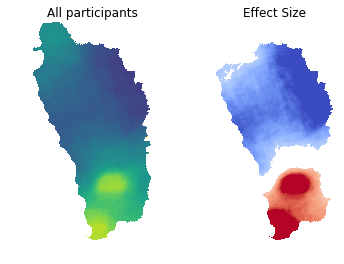

In [8]:
idx = df.participant=='yes'
A, md = stacker(df.loc[idx,'filename'].values,path="All rasters/",return_georeferencing=True)
N = np.sum(np.isfinite(A),axis=0)
A_ = np.nanmean(A,axis=0)

T,P = raster_stattest(A,'ttest_1samp',popmean=2.5)

D = cohen1(T,N)
Dmask = d_mask(D,P)

plt.subplot(121)
plt.imshow(A_,vmin=1,vmax=4,)
plt.title('All participants')
plt.axis('off')

plt.subplot(122)
plt.imshow(Dmask,vmin=-.8,vmax=.8,cmap='coolwarm')
plt.title('Effect Size')
plt.axis('off')

plt.savefig('all_participants_from_mean.png',dpi=300,bbox_inches='tight')

with rasterio.open('D_masked.tif', 'w', driver='GTiff', 
                             height=md['raster_size'][0], width=md['raster_size'][1],
                             count=1, dtype=np.float32, transform=md['affine']) as src:
    src.write(Dmask.astype(np.float32), 1)
    
plt.imsave('D_masked.png',Dmask,cmap="coolwarm",vmin=-.8,vmax=.8,dpi=300)

## Example using one sample t-test compared to a single other raster

We might also want to compare how participants answer compared to experts.  Unlike the previous example, we will supply a raster of values for the population mean instead of a scalar value.

Could not read: 1.1.tif
Could not read: 1.4.tif
167 rasters loaded.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


1 rasters loaded.
(478, 258)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater_equal


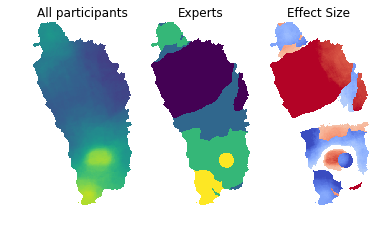

In [18]:
# Load the stacked raster, call it A
idx = df.participant=='yes'
A, md = stacker(df.loc[idx,'filename'].values,path="All rasters/",return_georeferencing=True)

A[A>4] = np.nan

N = np.sum(np.isfinite(A),axis=0)
A_ = np.nanmean(A,axis=0)


# Load the comparison raster, call it B
idx = df.participant=='no'
B = stacker(df.loc[idx,'filename'].values,path="All rasters/")
B = np.squeeze(B)
print(np.shape(B))

# Supply the B raster as the population raster
T,P = raster_stattest(A,'ttest_1samp',popmean=B)

D = cohen1(T,N)
Dmask = d_mask(D,P)

plt.subplot(131)
plt.imshow(A_,vmin=1,vmax=4,)
plt.title('All participants')
plt.axis('off')

plt.subplot(132)
plt.imshow(B,vmin=1,vmax=4,)
plt.title('Experts')
plt.axis('off')

plt.subplot(133)
plt.imshow(Dmask,vmin=-.8,vmax=.8,cmap='coolwarm')
plt.title('Effect Size')
plt.axis('off')

plt.savefig('all_participants_from_experts.png',dpi=300,bbox_inches='tight')

with rasterio.open('D_masked.tif', 'w', driver='GTiff', 
                             height=md['raster_size'][0], width=md['raster_size'][1],
                             count=1, dtype=np.float32, transform=md['affine']) as src:
    src.write(Dmask.astype(np.float32), 1)
    
plt.imsave('D_masked.png',Dmask,cmap="coolwarm",vmin=-.8,vmax=.8,dpi=300)


In [21]:
np.nanpercentile(A_,[5,95])

array([ 1.62275449,  3.41916168])

In [ ]:
plt.imshow(stats.mode(A,axis=0),nan_policy='omit')

C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


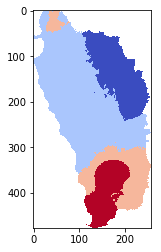

In [10]:
plt.imshow(np.nanmedian(A,axis=0),cmap='coolwarm')

## Example using independent t-tests

We might also be interested in comparing two different groups.  Comparing by gender is a good example of this.  To do this, we use an independent t-test.

Could not read: 1.1.tif
Could not read: 1.4.tif
77 rasters loaded.
90 rasters loaded.


C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
C:\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in less
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater_equal


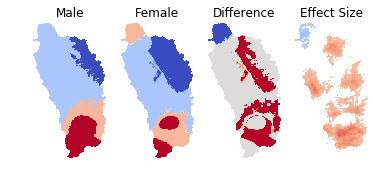

In [15]:
idx = df.gender=='male'
A,md = stacker(df.loc[idx,'filename'].values,path="All rasters/",return_georeferencing=True)
idx = df.gender=='female'
B = stacker(df.loc[idx,'filename'].values,path="All rasters/")
A_ = np.nanmedian(A,axis=0)
B_ = np.nanmedian(B,axis=0)

stack = (A,B)

T,P = raster_stattest(stack,'ttest_1samp',equal_var=False,nan_policy='omit')
D = cohen_d(A,B)
Dmask = d_mask(D,P)

plt.subplot(141)
plt.imshow(A_,vmin=1,vmax=4,cmap='coolwarm')
plt.title('Male')
plt.axis('off')

plt.subplot(142)
plt.imshow(B_,vmin=1,vmax=4,cmap='coolwarm')
plt.title('Female')
plt.axis('off')

plt.subplot(143)
plt.imshow(A_ - B_,vmin=-1,vmax=1,cmap='coolwarm')
plt.title('Difference')
plt.axis('off')

plt.subplot(144)
plt.imshow(Dmask,vmin=-.8,vmax=.8,cmap='coolwarm')
plt.title('Effect Size')
plt.axis('off')


plt.savefig('sex_differences_ttest.png',dpi=300,bbox_inches='tight')

# Save the masked D values
with rasterio.open('D_masked.tif', 'w', driver='GTiff', 
                             height=md['raster_size'][0], width=md['raster_size'][1],
                             count=1, dtype=np.float32, transform=md['affine']) as src:
    src.write(Dmask.astype(np.float32), 1)
plt.imsave('D_masked.png',Dmask,cmap="coolwarm",vmin=-.8,vmax=.8,dpi=300)

In [21]:
values = []
for i in range(len(stack)):
    values.append(np.nanmean(stack[i],axis=(1,2)))
values = tuple(values)
h,p = stats.kruskal(*values)
n = np.sum([len(item) for item in values])
k = len(values)
eta_squared = (h-k+1) / (n-k)
d = 2 * np.sqrt(eta_squared / (1-eta_squared))
print(d)

print(np.nanmean(D))

0.196168633199
-0.14129533691


In [14]:
np.nanmean(D)

-0.14129533691035079

### Independent sample t-tests with normalization

In some cases, the groups will differ in their overall mean rating.  In this case, it is may be useful to normalize the rasters before running statistics, by subtracting the group mean and dividing by the group standard deviation.  As an example, one can tell from both the summary statistics and plots above that men generally rate the island as more dangerous than women.  This overall effect can overwhelm the (perhaps) more interesting differences in _where_ the differences occur.  As an example, one could imagine men and women rating the individual movies in a popular sci-fi franchise.  The men might rate all the movies more highly on average than women, and yet both groups could have similar (or different!) relative preferences.  Similarly, applying a normalization of some kind helps to correct for these overall, larger-scale group differences in favor of seeing the relative, or local differences.

In [11]:
idx = df.gender=='male'
A,md = stacker(df.loc[idx,'filename'].values,path="All rasters/",return_georeferencing=True)
idx = df.gender=='female'
B = stacker(df.loc[idx,'filename'].values,path="All rasters/")

stacks = normalize((A,B))

A_ = np.nanmean(stacks[0],axis=0)
B_ = np.nanmean(stacks[1],axis=0)

T,P = raster_stattest(stacks,'ttest_1samp',equal_var=False,nan_policy='omit')
D = cohen_d(*stacks)
Dmask = d_mask(D,P)

Could not read: 1.1.tif
Could not read: 1.4.tif
77 rasters loaded.
90 rasters loaded.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
C:\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in less
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater_equal


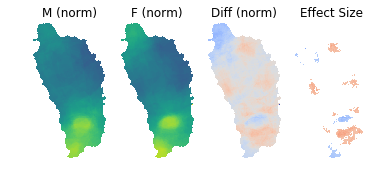

In [12]:
plt.subplot(141)
plt.imshow(A_,vmin=-1.5,vmax=1.5)
plt.title('M (norm)')
plt.axis('off')

plt.subplot(142)
plt.imshow(B_,vmin=-1.5,vmax=1.5)
plt.title('F (norm)')
plt.axis('off')

plt.subplot(143)
plt.imshow(A_ - B_,vmin=-1,vmax=1,cmap='coolwarm')
plt.title('Diff (norm)')
plt.axis('off')

plt.subplot(144)
plt.imshow(Dmask,vmin=-.8,vmax=.8,cmap='coolwarm')
plt.title('Effect Size')
plt.axis('off')


plt.savefig('sex_differences_ttest_normed.png',dpi=300,bbox_inches='tight')

# Save the masked D values
with rasterio.open('D_masked.tif', 'w', driver='GTiff', 
                             height=md['raster_size'][0], width=md['raster_size'][1],
                             count=1, dtype=np.float32, transform=md['affine']) as src:
    src.write(Dmask.astype(np.float32), 1)
plt.imsave('D_masked.png',Dmask,cmap="coolwarm",vmin=-.8,vmax=.8,dpi=300)

## Robust Statistics on Two Independent Groups (Mann Whitney U)

In some cases, it may not be appropriate to run parametric statistics.  In these cases, we provide a method for comparing two independent groups using Mann Whitney U.  Since U does not appear negative, one should take care to interpret the effect size as a magnitude, but not a direction.

In [13]:
#%% Non-parametric example, difference in medians (Mann-Whitney U)

idx = df.gender=='male'
A, md = stacker(df.loc[idx,'filename'].values,path="All rasters/",return_georeferencing=True)
idx = df.gender=='female'
B = stacker(df.loc[idx,'filename'].values,path="All rasters/")

stack = (A,B)

A_ = np.nanmean(stacks[0],axis=0)
B_ = np.nanmean(stacks[1],axis=0)

U,P = raster_stattest(stack,'mannwhitneyu')
n1 = np.shape(A)[0]
n2 = np.shape(B)[0]
D = cohen_from_U(U,n1,n2)
Dmask = d_mask(D,P,.2,.05)

Could not read: 1.1.tif
Could not read: 1.4.tif
77 rasters loaded.
90 rasters loaded.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in less
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater_equal


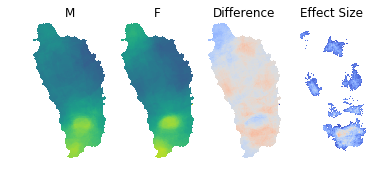

In [14]:
plt.subplot(141)
plt.imshow(A_,vmin=-1.5,vmax=1.5)
plt.title('M')
plt.axis('off')

plt.subplot(142)
plt.imshow(B_,vmin=-1.5,vmax=1.5)
plt.title('F')
plt.axis('off')

plt.subplot(143)
plt.imshow(A_ - B_,vmin=-1,vmax=1,cmap='coolwarm')
plt.title('Difference')
plt.axis('off')

plt.subplot(144)
plt.imshow(Dmask,vmin=.2,vmax=.8,cmap='coolwarm')
plt.title('Effect Size')
plt.axis('off')


plt.savefig('sex_differences_ttest_robust.png',dpi=300,bbox_inches='tight')

# Save the masked D values
with rasterio.open('D_masked.tif', 'w', driver='GTiff', 
                             height=md['raster_size'][0], width=md['raster_size'][1],
                             count=1, dtype=np.float32, transform=md['affine']) as src:
    src.write(Dmask.astype(np.float32), 1)
plt.imsave('D_masked.png',Dmask,cmap="coolwarm",vmin=.2,vmax=.8,dpi=300)

## Robust statistics on 3 or more groups (Kruskal Wallis)

For more than 2 groups, one can compute a one-way ANOVA or perform a Kruskal Wallis test.  In this case, it is quite simple to compute the effect size for the Kruskal Wallis test, so only this one has been implemented so far.  

In [15]:
idx = df.age=='young'
A, md = stacker(df.loc[idx,'filename'].values,path="All rasters/",return_georeferencing=True)
idx = df.age=='mid'
B = stacker(df.loc[idx,'filename'].values,path="All rasters/")
idx = df.age=='older'
C = stacker(df.loc[idx,'filename'].values,path="All rasters/")

stack = (A,B,C)

N = np.sum(stack_counts(stack),axis=0)

H,P = raster_stattest(stack,'kruskal')
D = cohen_from_H(H,N,k=len(stack))
Dmask = d_mask(D,P,.2,.05)

44 rasters loaded.
Could not read: 1.1.tif
Could not read: 1.4.tif
71 rasters loaded.
52 rasters loaded.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in less
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in less
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater_equal


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


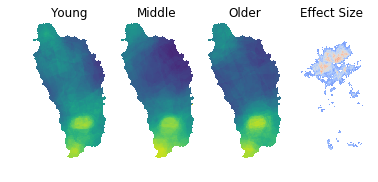

In [16]:
plt.subplot(141)
plt.imshow(np.nanmean(A,axis=0),vmin=1,vmax=4)
plt.title('Young')
plt.axis('off')

plt.subplot(142)
plt.imshow(np.nanmean(B,axis=0),vmin=1,vmax=4)
plt.title('Middle')
plt.axis('off')

plt.subplot(143)
plt.imshow(np.nanmean(C,axis=0),vmin=1,vmax=4)
plt.title('Older')
plt.axis('off')

plt.subplot(144)
plt.imshow(Dmask,vmin=.2,vmax=.8,cmap='coolwarm')
plt.title('Effect Size')
plt.axis('off')

plt.savefig('age_differences_effect_size.png',dpi=300,bbox_inches='tight')

# Save the masked D values
with rasterio.open('D_masked.tif', 'w', driver='GTiff', 
                             height=md['raster_size'][0], width=md['raster_size'][1],
                             count=1, dtype=np.float32, transform=md['affine']) as src:
    src.write(Dmask.astype(np.float32), 1)

# With more than 2 groups, effect sizes aren't negative.
plt.imsave('D_masked.png',Dmask,cmap="coolwarm",vmin=.2,vmax=.8,dpi=300)

## Keeping it simple

The Kruskal-Wallis test provides a robust analysis for two or more groups, and is a good default choice, even when the the data are normally distributed and with only two groups in comparison.  Comment/uncomment the normalization line, as desired.

Could not read: 1.1.tif
Could not read: 1.4.tif
77 rasters loaded.
90 rasters loaded.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in less
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in less
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater_equal


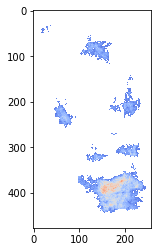

In [17]:
idx = df.gender=='male'
A, md = stacker(df.loc[idx,'filename'].values,path="All rasters/",return_georeferencing=True)
idx = df.gender=='female'
B = stacker(df.loc[idx,'filename'].values,path="All rasters/")

# Create aggregates, if desired:
A_ = np.nanmean(A,axis=0)
B_ = np.nanmean(B,axis=0)

# Create difference raster, if desired
C = A_ - B_

# Stack rasters; normalize if desired
stack = (A,B)
# stack = normalize(stack)

#C Count total responses per cell
N = np.sum(stack_counts(stack),axis=0)

# Calculate statistics and masks
H,P = raster_stattest(stack,'kruskal')
D = cohen_from_H(H,N,k=len(stack))
Dmask = d_mask(D,P,.2,.05)

plt.imshow(Dmask,vmin=.2,vmax=.8,cmap='coolwarm')

# Save the masked D values
with rasterio.open('D_masked.tif', 'w', driver='GTiff', 
                             height=md['raster_size'][0], width=md['raster_size'][1],
                             count=1, dtype=np.float32, transform=md['affine']) as src:
    src.write(Dmask.astype(np.float32), 1)

# With more than 2 groups, effect sizes aren't negative.
plt.imsave('D_masked.png',Dmask,cmap="coolwarm",vmin=.2,vmax=.8,dpi=300)

In [18]:
# If desired, save individual rasters and/or difference rasters

# Save the value.  Change filename, etc., as desired

raster_to_write = A_
filename = 'out'
vmin = 1
vmax = 4
cmap = "coolwarm"

with rasterio.open(filename + '.tif', 'w', driver='GTiff', 
                             height=md['raster_size'][0], width=md['raster_size'][1],
                             count=1, dtype=np.float32, transform=md['affine']) as src:
    src.write(raster_to_write.astype(np.float32), 1)
    
    
plt.imsave(filename + '.png',raster_to_write,cmap=cmap,vmin=vmin,vmax=vmax,dpi=300)